In [ ]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy
import multidop
import pyart
import tempfile
import os
import glob
import time


from pycwr.io.auto_io import radar_io 
import numpy as np
import pandas as pd
import xarray as xr
import pyart

f1 = r"/home/liyuan3970/study_demo/met_plot/rader/pup/pintu/Z_RADR_I_Z9571_20190809172500_O_DOR_SA_CAP.bin.bz2"
f2 = r"/home/liyuan3970/study_demo/met_plot/rader/pup/pintu/Z_RADR_I_Z9577_20190809172500_O_DOR_SA_CAP.bin.bz2"
basedata1 = radar_io(f1) 
basedata2 = radar_io(f2)

r1 = basedata1.ToPyartRadar()
r2 = basedata2.ToPyartRadar()


cp1 = deepcopy(r1.fields['reflectivity']['data'])
r1.add_field_like('reflectivity', 'DT', cp1, replace_existing=True)
gatefilter1 = pyart.correct.GateFilter(r1)
gatefilter1.exclude_masked('reflectivity')
corr_vel1 = pyart.correct.dealias_region_based(
    r1, vel_field='velocity', keep_original=False, 
    gatefilter=gatefilter1, centered=True)
r1.add_field('VT', corr_vel1, replace_existing=True)



cp2 = deepcopy(r2.fields['reflectivity']['data'])
r2.add_field_like('reflectivity', 'DT', cp2, replace_existing=True)
gatefilter2 = pyart.correct.GateFilter(r2)
gatefilter2.exclude_masked('reflectivity')
corr_vel2 = pyart.correct.dealias_region_based(
    r2, vel_field='velocity', keep_original=False, 
    gatefilter=gatefilter2, centered=True)
r2.add_field('VT', corr_vel2, replace_existing=True)



# The analysis engine currently expects the "missing_value" attribute
r1.fields['DT']['missing_value'] = 1.0 * r1.fields['DT']['_FillValue']
r2.fields['DT']['missing_value'] = 1.0 * r2.fields['DT']['_FillValue']
r1.fields['VT']['missing_value'] = 1.0 * r1.fields['VT']['_FillValue']
r2.fields['VT']['missing_value'] = 1.0 * r2.fields['VT']['_FillValue']

radars1 =[r1]
grids1 = pyart.map.grid_from_radars(
         radars1, grid_shape=(46, 251, 251),
        grid_limits=((0, 15000.0),(-150000, 150000), (-150000, 150000)),
        fields=['reflectivity','DT','VT'], gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')

radars2 =[r2]
grids2 = pyart.map.grid_from_radars(
         radars2, grid_shape=(46, 251, 251),
        grid_limits=((0, 15000.0),(-150000, 150000), (-150000, 150000)),
        fields=['reflectivity','DT','VT'], gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/liyuan3970/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/pandas/core/tools/datetimes.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(key, collections.Hashable):
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/h5py/_hl/base.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.a

In [1]:
import numpy as np
import pyart
import gc
import os
import tempfile

# We want cfgrib to be an optional dependency to ensure Windows compatibility
try:
    import cfgrib
    CFGRIB_AVAILABLE = True
except:
    CFGRIB_AVAILABLE = False

# We really only need the API to download the data, make ECMWF API an
# optional dependency since not everyone will have a login from the start.
try:
    from ecmwfapi import ECMWFDataServer
    ECMWF_AVAILABLE = True
except:
    ECMWF_AVAILABLE = False

from netCDF4 import Dataset
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator, interp1d, griddata
from scipy.interpolate import NearestNDInterpolator
from copy import deepcopy



def make_initialization_from_era_interim(Grid, file_name=None, vel_field=None,
                                         dest_era_file=None):
    """
    This function will read ERA Interim in NetCDF format and add it
    to the Py-ART grid specified by Grid. PyDDA will automatically download
    the ERA Interim data that you need for the scan. It will chose the domain
    that is enclosed by the analysis grid and the time period that is closest
    to the scan. It will then do a Nearest Neighbor interpolation of the
    ERA-Interim u and v winds to the analysis grid.

    You need to have the ECMWF API and an ECMWF account set up in order to
    use this feature. Go to this website for instructions on installing the
    API and setting up your account:

    https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets

    Parameters
    ----------
    Grid: Py-ART Grid
        The input Py-ART Grid to modify.
    file_name: str or None
        The netCDF file containing the ERA Interim data. If the web
        API is experiencing delays, it is better to use it to download the
        file and then refer to it here. If this file does not exist
        PyDDA will use the API to create the file.
    vel_field: str or None
        The name of the velocity field in the Py-ART grid. Set to None to
        have Py-DDA attempt to automatically detect it.
    dest_era_file:
        If this is not None, PyDDA will save the interpolated grid into this file.
    Returns
    -------
    new_Grid: Py-ART Grid
        The Py-ART Grid with the ERA Interim data added into the "u_erainterim",
        "v_erainterim", and "w_erainterim" fields.

    """
    if vel_field is None:
        vel_field = pyart.config.get_field_name('corrected_velocity')

    if ECMWF_AVAILABLE is False and file_name is None:
        raise (ModuleNotFoundError,
               ("The ECMWF API is not installed. Go to" +
                "https://confluence.ecmwf.int/display/WEBAPI" +
                "/Access+ECMWF+Public+Datasets" +
                " in order to use the auto download feature."))

    grid_time = datetime.strptime(Grid.time["units"],
                                  "seconds since %Y-%m-%dT%H:%M:%SZ")
    hour_rounded_to_nearest_3 = int(3 * round(float(grid_time.hour)/3))

    if hour_rounded_to_nearest_3 == 24:
        grid_time = grid_time + timedelta(days=1)
        grid_time = datetime(grid_time.year, grid_time.month,
                             grid_time.day, 0, grid_time.minute,
                             grid_time.second)
    else:
        grid_time = datetime(grid_time.year, grid_time.month,
                             grid_time.day,
                             hour_rounded_to_nearest_3,
                             grid_time.minute, grid_time.second)

    if file_name is not None:
        if not os.path.isfile(file_name):
            raise FileNotFoundError(file_name + " not found!")

    if file_name is None:
        print("Download ERA Interim data...")
        # ERA interim data is in pressure coordinates
        # Retrieve u, v, w, and geopotential
        # Geopotential is needed to convert into height coordinates

        retrieve_dict = {}
        retrieve_dict['stream'] = "oper"
        retrieve_dict['levtype'] = "pl"
        retrieve_dict['param'] = "131.128/132.128/135.128/129.128"
        retrieve_dict['dataset'] = "interim"
        retrieve_dict['levelist'] = ("1/2/3/5/7/10/20/30/50/70/100/125/150/" +
                                     "175/200/225/250/300/350/400/450/500/" +
                                     "550/600/650/700/750/775/800/825/850/" +
                                     "875/900/925/950/975/1000")
        retrieve_dict['step'] = "%d" % grid_time.hour
        retrieve_dict['date'] = grid_time.strftime("%Y-%m-%d")
        retrieve_dict['class'] = "ei"
        retrieve_dict['grid'] = "0.75/0.75"
        N = "%4.1f" % Grid.point_latitude["data"].max()
        S = "%4.1f" % Grid.point_latitude["data"].min()
        E = "%4.1f" % Grid.point_longitude["data"].max()
        W = "%4.1f" % Grid.point_longitude["data"].min()

        retrieve_dict['area'] = N + "/" + W + "/" + S + "/" + E
        retrieve_dict['format'] = "netcdf"
        if dest_era_file is not None:
            retrieve_dict['target'] = dest_era_file
            file_name = dest_era_file
        else:
            tfile = tempfile.NamedTemporaryFile()
            retrieve_dict['target'] = tfile.name
            file_name = tfile.name
        server = ECMWFDataServer()
        server.retrieve(retrieve_dict)

    ERA_grid = Dataset(file_name, mode='r')
    base_time = datetime.strptime(ERA_grid.variables["time"].units,
                                  "hours since %Y-%m-%d %H:%M:%S.%f")
    time_seconds = ERA_grid.variables["time"][:]
    our_time = np.array([base_time + timedelta(seconds=int(x)) for x in time_seconds])
    time_step = np.argmin(np.abs(base_time - grid_time))

    analysis_grid_shape = Grid.fields[vel_field]['data'].shape

    height_ERA = ERA_grid.variables["z"][:]
    u_ERA = ERA_grid.variables["u"][:]
    v_ERA = ERA_grid.variables["v"][:]
    w_ERA = ERA_grid.variables["w"][:]
    lon_ERA = ERA_grid.variables["longitude"][:]
    lat_ERA = ERA_grid.variables["latitude"][:]
    radar_grid_lat = Grid.point_latitude['data']
    radar_grid_lon = Grid.point_longitude['data']
    radar_grid_alt = Grid.point_z['data']
    u_flattened = u_ERA[time_step].flatten()
    v_flattened = v_ERA[time_step].flatten()
    w_flattened = w_ERA[time_step].flatten()

    the_shape = u_ERA.shape
    lon_mgrid, lat_mgrid = np.meshgrid(lon_ERA, lat_ERA)

    lon_mgrid = np.tile(lon_mgrid, (the_shape[1], 1, 1))
    lat_mgrid = np.tile(lat_mgrid, (the_shape[1], 1, 1))
    lon_flattened = lon_mgrid.flatten()
    lat_flattened = lat_mgrid.flatten()
    height_flattened = height_ERA[time_step].flatten()
    height_flattened -= Grid.radar_altitude["data"]

    u_interp = NearestNDInterpolator(
        (height_flattened, lat_flattened, lon_flattened),
        u_flattened, rescale=True)
    v_interp = NearestNDInterpolator(
        (height_flattened, lat_flattened, lon_flattened),
        v_flattened, rescale=True)
    w_interp = NearestNDInterpolator(
        (height_flattened, lat_flattened, lon_flattened),
        w_flattened, rescale=True)
    u_new = u_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)
    v_new = v_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)
    w_new = w_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)

    # Free up memory
    ERA_grid.close()

    if 'tfile' in locals():
        tfile.close()

    return u_new, v_new, w_new


def make_constant_wind_field(Grid, wind=(0.0, 0.0, 0.0), vel_field=None):
    """
    This function makes a constant wind field given a wind vector.

    This function is useful for specifying the intialization arrays
    for get_dd_wind_field.

    Parameters
    ==========

    Grid: Py-ART Grid object
        This is the Py-ART Grid containing the coordinates for the analysis
        grid.
    wind: 3-tuple of floats
        The 3-tuple specifying the (u,v,w) of the wind field.
    vel_field: String
        The name of the velocity field. None will automatically
        try to detect this field.

    Returns
    =======

    u: 3D float array
        Returns a 3D float array containing the u component of the wind field.
        The shape will be the same shape as the fields in Grid.
    v: 3D float array
        Returns a 3D float array containing the v component of the wind field.
        The shape will be the same shape as the fields in Grid.
    w: 3D float array
        Returns a 3D float array containing the u component of the wind field.
        The shape will be the same shape as the fields in Grid.
    """

    # Parse names of velocity field
    if vel_field is None:
        vel_field = pyart.config.get_field_name('corrected_velocity')
    analysis_grid_shape = Grid.fields[vel_field]['data'].shape

    u = wind[0]*np.ones(analysis_grid_shape)
    v = wind[1]*np.ones(analysis_grid_shape)
    w = wind[2]*np.ones(analysis_grid_shape)
    u = np.ma.filled(u, 0)
    v = np.ma.filled(v, 0)
    w = np.ma.filled(w, 0)
    return u, v, w


def make_wind_field_from_profile(Grid, profile, vel_field=None):
    """
    This function makes a 3D wind field from a sounding.

    This function is useful for using sounding data as an initialization
    for get_dd_wind_field.

    Parameters
    ==========
    Grid: Py-ART Grid object
        This is the Py-ART Grid containing the coordinates for the analysis
        grid.
    profile: PyART HorizontalWindProfile
        This is the HorizontalWindProfile of the sounding
    wind: 3-tuple of floats
        The 3-tuple specifying the (u,v,w) of the wind field.
    vel_field: String
        The name of the velocity field in Grid. None will automatically
        try to detect this field.

    Returns
    =======

    u: 3D float array
        Returns a 3D float array containing the u component of the wind field.
        The shape will be the same shape as the fields in Grid.
    v: 3D float array
        Returns a 3D float array containing the v component of the wind field.
        The shape will be the same shape as the fields in Grid.
    w: 3D float array
        Returns a 3D float array containing the u component of the wind field.
        The shape will be the same shape as the fields in Grid.
        """
    # Parse names of velocity field
    if vel_field is None:
        vel_field = pyart.config.get_field_name('corrected_velocity')
    analysis_grid_shape = Grid.fields[vel_field]['data'].shape
    u = np.ones(analysis_grid_shape)
    v = np.ones(analysis_grid_shape)
    w = np.zeros(analysis_grid_shape)
    u_back = profile.u_wind
    v_back = profile.v_wind
    z_back = profile.height
    u_interp = interp1d(
        z_back, u_back, bounds_error=False, fill_value='extrapolate')
    v_interp = interp1d(
        z_back, v_back, bounds_error=False, fill_value='extrapolate')
    u_back2 = u_interp(np.asarray(Grid.z['data']))
    v_back2 = v_interp(np.asarray(Grid.z['data']))
    for i in range(analysis_grid_shape[0]):
        u[i] = u_back2[i]
        v[i] = v_back2[i]
    u = np.ma.filled(u, 0)
    v = np.ma.filled(v, 0)
    w = np.ma.filled(w, 0)
    return u, v, w


def make_background_from_wrf(Grid, file_path, wrf_time,
                             radar_loc, vel_field=None):
    """
    This function makes an initalization field based off of the u and w
    from a WRF run. Only u and v are used from the WRF file.

    Parameters
    ----------
    Grid: Py-ART Grid object
        This is the Py-ART Grid containing the coordinates for the
        analysis grid.
    file_path: str
        This is the path to the WRF grid
    wrf_time: datetime
        The timestep to derive the intialization field from.
    radar_loc: tuple
        The (X, Y) location of the radar in the WRF grid. The output
        coordinate system will be centered around this location
        and given the same grid specification that is specified
        in Grid.
    vel_field: str, or None
        This string contains the name of the velocity field in the
        Grid. None will try to automatically detect this value.

    Returns
    -------
    u: 3D ndarray
        The initialization u field.
        The shape will be the same shape as the fields in Grid and will
        correspond to the same x, y, and z locations as in Grid.
    v: 3D ndarray
        The initialization v field.
        The shape will be the same shape as the fields in Grid and will
        correspond to the same x, y, and z locations as in Grid.
    w: 3D ndarray
        The initialization w field. The shape will be the same shape 
        as the fields in Grid and will correspond to the same x, y, and z
        locations as in Grid.

    """
    # Parse names of velocity field
    if vel_field is None:
        vel_field = pyart.config.get_field_name('corrected_velocity')

    analysis_grid_shape = Grid.fields[vel_field]['data'].shape
    u = np.ones(analysis_grid_shape)
    v = np.ones(analysis_grid_shape)
    w = np.zeros(analysis_grid_shape)

    # Load WRF grid
    wrf_cdf = Dataset(file_path, mode='r')
    W_wrf = wrf_cdf.variables['W'][:]
    V_wrf = wrf_cdf.variables['V'][:]
    U_wrf = wrf_cdf.variables['U'][:]
    PH_wrf = wrf_cdf.variables['PH'][:]
    PHB_wrf = wrf_cdf.variables['PHB'][:]
    alt_wrf = (PH_wrf+PHB_wrf)/9.81

    new_grid_x = Grid.point_x['data']
    new_grid_y = Grid.point_y['data']
    new_grid_z = Grid.point_z['data']

    # Find timestep from datetime
    time_wrf = wrf_cdf.variables['Times']
    ntimes = time_wrf.shape[0]
    dts_wrf = []
    for i in range(ntimes):
        x = ''.join([x.decode() for x in time_wrf[i]])
        dts_wrf.append(datetime.strptime(x, '%Y-%m-%d_%H:%M:%S'))

    dts_wrf = np.array(dts_wrf)
    timestep = np.where(dts_wrf == wrf_time)
    if(len(timestep[0]) == 0):
        raise ValueError(("Time " + str(wrf_time) + " not found in WRF file!"))

    x_len = wrf_cdf.__getattribute__('WEST-EAST_GRID_DIMENSION')
    y_len = wrf_cdf.__getattribute__('SOUTH-NORTH_GRID_DIMENSION')
    dx = wrf_cdf.DX
    dy = wrf_cdf.DY
    x = np.arange(0, x_len)*dx-radar_loc[0]*1e3
    y = np.arange(0, y_len)*dy-radar_loc[1]*1e3
    z = np.mean(alt_wrf[timestep[0], :, :, :], axis=(0, 2, 3))
    x, y, z = np.meshgrid(x, y, z)
    z = np.squeeze(alt_wrf[timestep[0], :, :, :])

    z_stag = (z[1:, :, :]+z[:-1, :, :])/2.0
    x_stag = (x[:, :, 1:]+x[:, :, :-1])/2.0
    y_stag = (y[:, 1:, :]+y[:, :-1, :])/2.0

    W_wrf = np.squeeze(W_wrf[timestep[0], :, :, :])
    V_wrf = np.squeeze(V_wrf[timestep[0], :, :, :])
    U_wrf = np.squeeze(U_wrf[timestep[0], :, :, :])

    w = griddata((z_stag, y, x), W_wrf,
                 (new_grid_z, new_grid_y, new_grid_x), fill_value=0.)
    v = griddata((z, y_stag, x), V_wrf,
                 (new_grid_z, new_grid_y, new_grid_x), fill_value=0.)
    u = griddata((z, y, x_stag), U_wrf,
                 (new_grid_z, new_grid_y, new_grid_x), fill_value=0.)

    return u, v, w


def make_intialization_from_hrrr(Grid, file_path):
    """
    This function will read an HRRR GRIB2 file and return initial guess
    u, v, and w fields from the model

    Parameters
    ----------
    Grid: Py-ART Grid
        The Py-ART Grid to use as the grid specification. The HRRR values
    will be interpolated to the Grid's specficiation and added as a field.
    file_path: string
        The path to the GRIB2 file to load.

    Returns
    -------
    Grid: Py-ART Grid
        This returns the Py-ART grid with the HRRR u, and v fields added.
        The shape will be the same shape as the fields in Grid and will
        correspond to the same x, y, and z locations as in Grid.
    """

    if(CFGRIB_AVAILABLE is False):
        raise RuntimeError(("The cfgrib optional dependency needs to be " +
                            "installed for the HRRR integration feature."))

    the_grib = cfgrib.open_file(
        file_path, filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

    # Load the HRR data and tranform longitude coordinates
    grb_u = the_grib.variables['u']
    grb_v = the_grib.variables['v']
    grb_w = the_grib.variables['w']
    gh = the_grib.variables['gh']

    lat = the_grib.variables['latitude'].data[:, :]
    lon = the_grib.variables['longitude'].data[:, :]
    lon[lon > 180] = lon[lon > 180] - 360

    # Convert geometric height to geopotential height
    EARTH_MEAN_RADIUS = 6.3781e6
    gh = gh.data[:, :, :]
    height = (EARTH_MEAN_RADIUS*gh)/(EARTH_MEAN_RADIUS-gh)
    height = height - Grid.radar_altitude['data']

    radar_grid_lat = Grid.point_latitude['data']
    radar_grid_lon = Grid.point_longitude['data']
    radar_grid_alt = Grid.point_z['data']
    lat_min = radar_grid_lat.min()
    lat_max = radar_grid_lat.max()
    lon_min = radar_grid_lon.min()
    lon_max = radar_grid_lon.max()
    lon_r = np.tile(lon, (height.shape[0], 1, 1))
    lat_r = np.tile(lat, (height.shape[0], 1, 1))
    lon_flattened = lon_r.flatten()
    lat_flattened = lat_r.flatten()
    height_flattened = gh.flatten()
    the_box = np.where(np.logical_and.reduce(
                       (lon_flattened >= lon_min,
                        lat_flattened >= lat_min,
                        lon_flattened <= lon_max,
                        lat_flattened <= lat_max)))[0]

    lon_flattened = lon_flattened[the_box]
    lat_flattened = lat_flattened[the_box]
    height_flattened = height_flattened[the_box]

    u_flattened = grb_u.data[:, :, :].flatten()
    u_flattened = u_flattened[the_box]
    u_interp = NearestNDInterpolator(
        (height_flattened, lat_flattened, lon_flattened),
        u_flattened, rescale=True)
    u_new = u_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)

    v_flattened = grb_v.data[:, :, :].flatten()
    v_flattened = v_flattened[the_box]
    v_interp = NearestNDInterpolator(
        (height_flattened, lat_flattened, lon_flattened),
        v_flattened, rescale=True)
    v_new = v_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)

    w_flattened = grb_v.data[:, :, :].flatten()
    w_flattened = w_flattened[the_box]
    w_interp = NearestNDInterpolator(
        (height_flattened, lat_flattened, lon_flattened),
        w_flattened, rescale=True)
    w_new = w_interp(radar_grid_alt, radar_grid_lat, radar_grid_lon)

    del grb_u, grb_v, grb_w, lat, lon
    del the_grib
    gc.collect()

    return u_new, v_new, w_new



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/liyuan3970/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/pandas/core/tools/datetimes.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(key, collections.Hashable):
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/h5py/_hl/base.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.a

Download ERA Interim data...
2020-03-26 15:42:14 ECMWF API python library 1.5.0
2020-03-26 15:42:14 ECMWF API at https://api.ecmwf.int/v1
2020-03-26 15:42:17 Welcome li yuan
2020-03-26 15:42:18 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2020-03-26 15:42:21 Request submitted
2020-03-26 15:42:21 Request id: 5e7c5cdc72ce19fe54b403bc
2020-03-26 15:42:21 Request is submitted
2020-03-26 15:42:23 Request is active
Calling 'nice mars /tmp/95/95/tmp-_marsjPdxjm.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
PPDIR is /var/tmp/ppdir/x86_64
mars - INFO   - 20200326.074223 - Welcome to MARS
mars - INFO   - 20200326.074223 - MARS Client bundle version: 6.27.7.1
mars - INFO   - 20200326.074223 - MARS Client package v

/home/liyuan3970/anaconda3/lib/python3.7/site-packages/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2)/(2 * Re * slantr))


Starting solver 
rmsVR = 13.594418743888696
Total points: 2312641
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  48.5224|1042.6524|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  28.1169
Norm of gradient: 0.027333538705659022
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  17.7825| 524.8583|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  40.6753
Norm of gradient: 0.018060432275638354
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|   5.5197| 380.3967|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  44.8957
Norm of gradient: 0.0034060143476763705
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|   4.5468| 324.1365|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  46.5865
Norm of gradient: 0.006076480575877162
Iterations before filter: 40
| Jvel    | Jmass

/home/liyuan3970/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|39478.0999| 382.2981|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.4516
Norm of gradient: 0.536776173689988
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|38628.5814| 378.7888|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.4214
Norm of gradient: 0.5308967850517254
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  71.9038| 895.9430|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  34.4278
Norm of gradient: 0.03553631395452919
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  41.5274| 736.6116|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  35.2918
Norm of gradient: 0.034008081743944714
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|  39.8049| 547.9508|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  40.4180
Norm of gradient: 0.027695006638519135
| Jv

/home/liyuan3970/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


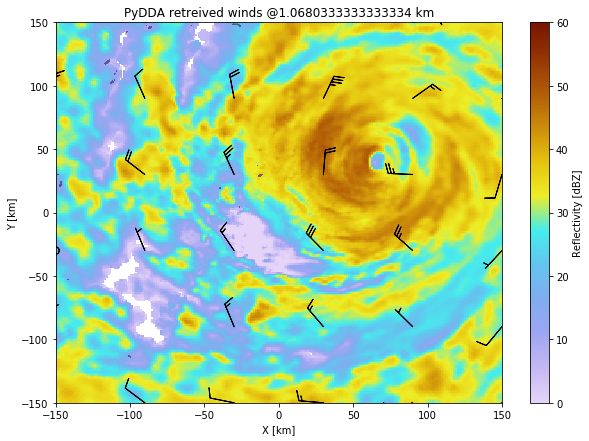

In [3]:
import pyart
import pydda
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Set initialization and do retrieval
u_init, v_init, w_init = make_initialization_from_era_interim(grids2, vel_field='VT')

new_grids = pydda.retrieval.get_dd_wind_field([grids2],
                                              u_init, v_init, w_init,
                                              vel_name='VT', refl_field='DT',
                                              mask_outside_opt=True)
# Make a neat plot
fig = plt.figure(figsize=(10,7))
ax = pydda.vis.plot_horiz_xsection_barbs(new_grids, background_field='DT', 
                                        level=1,vmin=0, vmax=60,
                                        w_vel_contours=[3, 6, 9, 12, 15],
                                        barb_spacing_x_km=60.0,
                                        barb_spacing_y_km=60.0)
#ax.set_xticks(np.arange(150.5, 153, 0.1))
#ax.set_yticks(np.arange(-36, -32.0, 0.1))
#ax.set_xlim([151.0, 151.35])
#ax.set_ylim([-34.15, -33.9])
plt.show(ax)


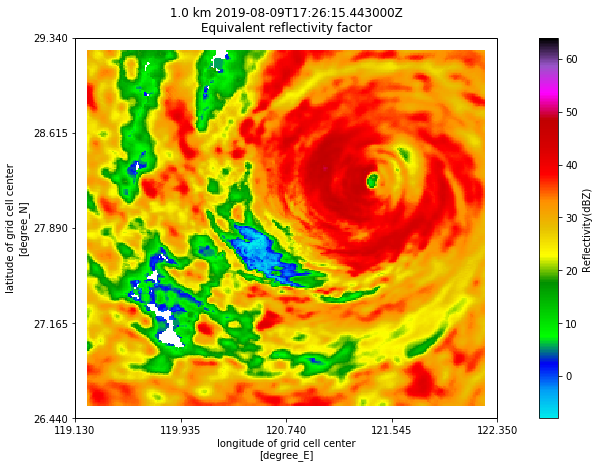

In [24]:
display = pyart.graph.GridMapDisplay(grids2)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# parameters
level = 3
vmin = -8
vmax = 64
lat = 36.5
lon = -98.0

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
#display.plot_basemap(lon_lines = np.arange(-104, -93, 2) )
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSRef)